#Preprocess Images

In [ ]:
import keras
import numpy as np
from tensorflow import data, image, io
from tqdm.notebook import tqdm
import os

In [ ]:
imageChannels = 3
maskChannels = 1

size = 128
imagePath = '/content/drive/MyDrive/DataSets/Roads/Road'
maskPath = '/content/drive/MyDrive/DataSets/Roads/Mask'
outputPath = '/content/drive/MyDrive/DataSets'

imagesData = []
filenames = []
masksData = []

In [ ]:
print(sorted(os.listdir(imagePath)))
print(sorted(os.listdir(maskPath)))

In [ ]:
for filename in  tqdm(sorted(os.listdir(imagePath))):
  path = os.path.join(imagePath, filename)
  img = io.read_file(path)
  img = image.decode_png(img, channels = 3)
  img = image.resize(img, (size, size))
  img = image.convert_image_dtype(img, "float32")
  imagesData.append(np.asarray(img))

imagesData = np.reshape(imagesData, (len(imagesData), size, size, imageChannels))
imagesData = imagesData / 255

print("saving file...")
np.save(os.path.join(outputPath, "imagesData.npy"), imagesData)
print("file saved!")

In [ ]:
masksData = []

for filename in  tqdm(sorted(os.listdir(maskPath))):
  path = os.path.join(maskPath, filename)
  img = io.read_file(path)
  img = image.decode_png(img, channels = maskChannels)
  img = image.resize(img, (size, size), method="nearest")
  img = image.convert_image_dtype(img, "uint8")
  masksData.append(np.asarray(img))

masksData = np.reshape(masksData, (len(masksData), size, size, maskChannels))
masksData = masksData / 255

print("saving file...")
np.save(os.path.join(outputPath, "masksData.npy"), masksData)
print("file saved!")

In [1]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, LayerNormalization, Activation, ZeroPadding2D, AveragePooling2D, GaussianNoise, UpSampling2D, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import load_model, save_model
from keras.datasets.cifar10 import load_data
from skimage.transform import resize
from keras import initializers, backend
from tensorflow.keras.utils import to_categorical
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
from tensorflow import data, image, io
import os
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
imageChannels = 3
maskChannels = 1

size = 128

In [ ]:
masksData = np.load('/content/drive/MyDrive/DataSets/masksData.npy')
imagesData = np.load('/content/drive/MyDrive/DataSets/imagesData.npy')

<function matplotlib.pyplot.show(close=None, block=None)>

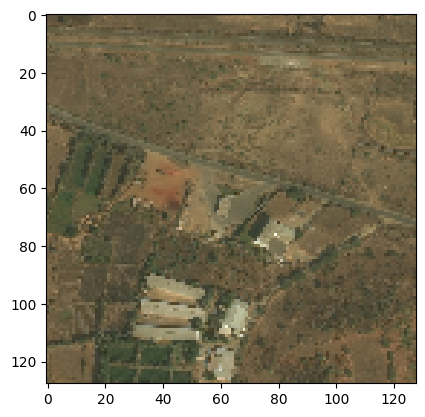

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(masksData, imagesData, test_size=0.2, random_state=42)

plt.imshow(imagesData[50], interpolation='nearest')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

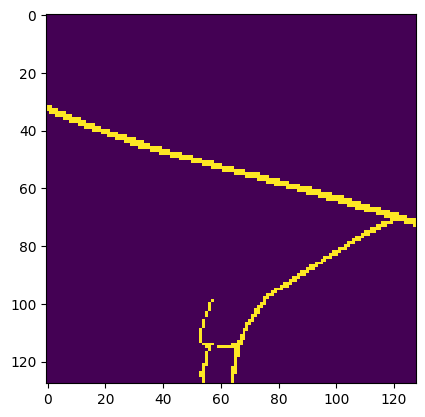

In [ ]:
plt.imshow(masksData[50], interpolation='nearest')
plt.show

#Model

In [ ]:
def roadModel():
  inputs = Input((size, size, maskChannels))

  model = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
  model = LeakyReLU(alpha=0.1)(model)
  model = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
  model = LeakyReLU(alpha=0.1)(model)
  model = AveragePooling2D()(model)

  model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = AveragePooling2D()(model)

  model = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = AveragePooling2D()(model)

  model = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = AveragePooling2D()(model)

# -------------------------------------------

  model = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)

# -------------------------------------------

  model = Conv2DTranspose(256, (3, 3),  strides = (2, 2), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)

  model = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)

  model = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)

  model = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(model)
  model = LeakyReLU(alpha=0.1)(model)

  model = Conv2D(imageChannels, (3, 3), padding='same', activation='tanh')(model)

  return Model(inputs, model)

In [ ]:
def optimizer():
  return Adam(learning_rate=0.0003, beta_1=0.5)
  #return RMSprop(lr = .0001, clipvalue = 1.0, decay = 1e-8)

#Training

In [ ]:
def trainModel():
  model = roadModel()
  model.summary()
  model.compile(optimizer=optimizer(), loss='binary_crossentropy')

  model.fit(X_train, y_train, epochs=50, batch_size=16)

  model.evaluate(X_test, y_test)

  model.save('/content/drive/MyDrive/DataSets/roadModel.keras')
  return model


In [ ]:
def trainModel(epocks = 50, batch_size = 32):
  model = roadModel()
  model.summary()
  model.compile(optimizer=optimizer(), loss='binary_crossentropy')

  for epoch in tqdm(range(epocks)):
    idx = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[idx]
    y_batch = y_train[idx]

    model.train_on_batch(X_batch, y_batch)
    # model.evaluate(X_test, y_test)

  model.evaluate(X_test, y_test)

  model.save('/content/drive/MyDrive/DataSets/roadModel.keras')
  return model




In [ ]:
trainModel()

In [ ]:
def continueTrainModel():
  model = load_model('/content/drive/MyDrive/DataSets/roadModel.keras')

  model.fit(X_train, y_train, epochs=150, batch_size=16)

  model.evaluate(X_test, y_test)

  model.save('/content/drive/MyDrive/DataSets/roadModel1.keras')
  return model

In [ ]:
continueTrainModel()

# See Results



In [ ]:
testData = []
test = io.read_file('/content/drive/MyDrive/DataSets/Roads/RoadTestMask.png')
test = image.decode_png(test, channels = 1)
test = image.resize(test, (size, size))
test = image.convert_image_dtype(test, "uint8")
testData.append(np.asarray(test))

testData = np.reshape(testData, (len(testData), size, size, maskChannels))
testData = testData / 255

print("saving file...")
np.save(os.path.join('/content/drive/MyDrive/DataSets/Roads', "testData.npy"), testData)
print("file saved!")

In [4]:
loadedModel = load_model('/content/drive/MyDrive/DataSets/roadModel1.keras')

In [22]:
def save_images(cnt, noise, generator):
  image_array = np.full((128, 128, 3), 255, dtype=np.uint8)
  generated_images = generator.predict(noise)
  generated_images = generated_images
  image_count = 0
  for row in range(1):
    for col in range(1):
      r = row * size
      c = col * size
      image_array[r:r + size, c:c + size] = generated_images[image_count] * 255
      image_count += 1
  output_path = '/content/drive/MyDrive/DataSets'
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  filename = os.path.join(output_path, f"trained-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)
  return filename

In [ ]:
save_images(6, testData, loadedModel)